In [1]:
import sys as _sys
import os

currentPath = os.path.abspath(os.getcwd())

split = currentPath.split("CShells")
if len(split)<2:
    print("Please rename the repository 'CShells'")
    raise ValueError
pathToPythonScripts = split[0] + "CShells/python/"
pathToCubicSplines  = split[0] + "CShells/ext/torchcubicspline/"

_sys.path.insert(0, pathToPythonScripts)
_sys.path.insert(0, pathToCubicSplines)

In [2]:
import MeshFEM
import ElasticRods

import average_angle_linkages
from bending_validation import suppress_stdout as so
import elastic_rods
import json
from linkage_vis import LinkageViewer
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import torch

from CShell import CShell, GetEdgesFromCurves
from CShellToJSON import ExtractQuantitiesPerSegment
from LinkageTopologies import RegularTopology
from open_average_angle_linkage import open_average_angle_linkage
import py_newton_optimizer

torch.set_default_dtype(torch.float64)
    
def ToNumpy(tensor):
    return tensor.cpu().detach().clone().numpy()

PI = math.pi

# Define a compatible linkage

In [3]:


nJa  = 3 # Number of joints for the first family of joints
nJb  = 2  # Number of joints for the second family of joints

nJ, curves, curvesFamily = RegularTopology(nJa, nJb)

lengthX   = 10.0
lengthY   = 7.0

xPos = torch.tile(torch.linspace(0, lengthX, nJa), (nJb,))
yPos = torch.repeat_interleave(torch.linspace(0, lengthY, nJb), nJa, dim=0)

xOffset = 0.5
yOffset = 0.8
xPos   += xOffset * torch.tensor([0.0, -1.0, 0.0, 0.0, 1.0, 0.0])
yPos   += yOffset * torch.tensor([1.0, 0.0, 1.0, -1.0, 0.0, -1.0])

joints = torch.zeros(size=(nJ, 3))
joints[:, 0] = xPos
joints[:, 1] = yPos

rodEdges, rodEdgeToCurve = GetEdgesFromCurves(curves)

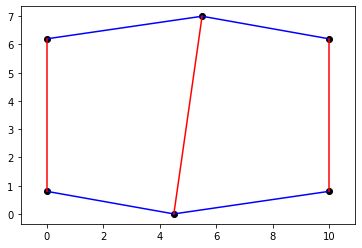

In [6]:
for (crv, fam) in zip(curves, curvesFamily):
    if fam==0:
        plt.plot(joints[crv, 0], joints[crv, 1], c='b')
    else:
        plt.plot(joints[crv, 0], joints[crv, 1], c='r')
plt.scatter(joints[:, 0], joints[:, 1], c='k')
plt.axis('equal')
plt.show()

In [29]:
jointsPosition = ToNumpy(joints)
rodMaterial    = elastic_rods.RodMaterial('rectangle', 2000, 0.3, [0.60, 0.30])

# For the discretization
subdivision = 10

flatLinkageComp = elastic_rods.RodLinkage(jointsPosition, rodEdges,
                                          rod_interleaving_type=elastic_rods.InterleavingType.xshell, subdivision=subdivision)
flatLinkageComp = average_angle_linkages.AverageAngleLinkage(flatLinkageComp)

driver = flatLinkageComp.centralJoint()
flatLinkageComp.setMaterial(rodMaterial)
flatLinkageComp.set_design_parameter_config(True, True, True) # Keep length, remove rest curvature, and update the design parameters

jdo       = flatLinkageComp.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(flatLinkageComp, fixedVars=fixedVars)

flatViewComp = LinkageViewer(flatLinkageComp, width=1024, height=640)

In [30]:
flatViewComp.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [31]:
deployedLinkageComp = average_angle_linkages.AverageAngleLinkage(flatLinkageComp)
deployedViewComp    = LinkageViewer(deployedLinkageComp, width=1024, height=640)

def equilibriumSolver(tgtAngle, l, opts, fv):
    opts.gradTol = 1.0e-4
    return average_angle_linkages.compute_equilibrium(l, tgtAngle, options=opts, fixedVars=fv)

deployedViewComp.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [32]:
alphaTar        = np.deg2rad(155)
numOpeningSteps = 40
maxNewtonIterIntermediate = 20

with so(): open_average_angle_linkage(deployedLinkageComp, driver, alphaTar - deployedLinkageComp.averageJointAngle, numOpeningSteps, 
                                      deployedViewComp, equilibriumSolver=equilibriumSolver, 
                                      maxNewtonIterationsIntermediate=maxNewtonIterIntermediate)

# Define a C-shell

In [33]:
mult = 5
subdivision = 10

nCPperRodEdge = [(len(crv) - 1) * [1] for crv in curves]
totNCP = sum([sum(el) for el in nCPperRodEdge])
curvesDoF = torch.zeros(size=(2 * nJ + totNCP,))
curvesDoF[:2*nJ]  = torch.tensor(flatLinkageComp.jointPositions().reshape(-1, 3)[:, :2].reshape(-1,))
curvesDoF[2*nJ] = -0.15
curvesDoF[2*nJ+1] = -0.15
curvesDoF[2*nJ+2] = 0.15
curvesDoF[2*nJ+3] = 0.15

cshell = CShell(
    curvesDoF, nJ, curves, curvesFamily, nCPperRodEdge, alphaTar, mult, subdivision, 
    rodMaterial=rodMaterial, pathSurf=None, newtonOptimizerOptions=None, optimizeAlpha=True, 
    useSAL=False, attractionMesh=None, targetMesh=None,
    dictWeights=None, linkagesGuess=None,
    numOpeningSteps=40, maxNewtonIterIntermediate=20, flatOnly=False
)

deltaAlpha = cshell.flatLinkage.averageJointAngle - flatLinkageComp.averageJointAngle
deltaAlpha = 0.3

alphaTarCshell = cshell.alphaTar + 0.1

cshell = CShell(
    curvesDoF, nJ, curves, curvesFamily, nCPperRodEdge, alphaTarCshell, mult, subdivision, 
    rodMaterial=rodMaterial, pathSurf=None, newtonOptimizerOptions=None, optimizeAlpha=True, 
    useSAL=False, attractionMesh=None, targetMesh=None,
    dictWeights=None, linkagesGuess=None,
    numOpeningSteps=40, maxNewtonIterIntermediate=20, flatOnly=False
)

Flat equilibrium solve
0	1.44297e-19	5.00246e-09	5.00246e-09	0	0
Deployed equilibrium solve
Initial energy (deployed) 0.800306
Has constraints: 0
0	0.800306	4.83173e-07	4.83173e-07	1	0
1	0.800306	7.09482e-12	7.09482e-12	1	0
Final energy (deployed) 0.800306
Flat equilibrium solve
0	1.44297e-19	5.00246e-09	5.00246e-09	0	0
Deployed equilibrium solve
Initial energy (deployed) 0.800306
Has constraints: 0
0	0.800306	6.7849e-12	6.7849e-12	0	0
Final energy (deployed) 0.800306
Saved 109 vertices and 192 triangles
Saved 109 vertices and 192 triangles
Flat equilibrium solve
0	1.44271e-19	5.00313e-09	5.00313e-09	0	0
Deployed equilibrium solve
Initial energy (deployed) 1.00312
Has constraints: 0
0	1.00312	2.82036e-08	2.82036e-08	0	0
Final energy (deployed) 1.00312
Flat equilibrium solve
0	1.44271e-19	5.00313e-09	5.00313e-09	0	0
Deployed equilibrium solve
Initial energy (deployed) 1.00312
Has constraints: 0
0	1.00312	2.82036e-08	2.82036e-08	0	0
Final energy (deployed) 1.00312
Saved 109 vertices and 

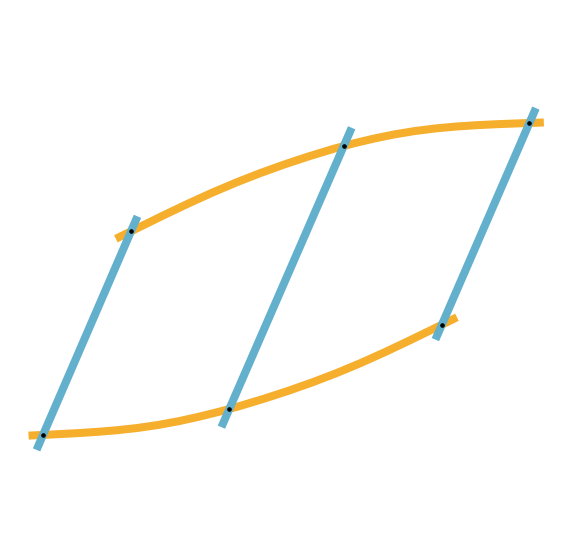

In [35]:
cshell.PlotCurveLinkage()

In [36]:
cshell.deployedView.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

# Interpolate the rest quantities

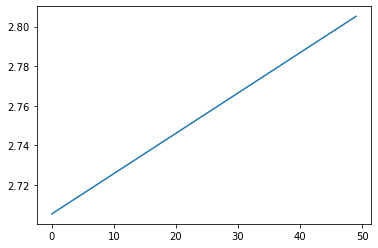

In [39]:
pathToSaveJSON = "../../output/straight_to_curved/interpolated_models/"

n_inter_frames = 13
n_jsons = 2

knots = np.linspace(0.0, 1.0, n_jsons)
n_steps = n_inter_frames * (n_jsons - 1) + n_jsons
ts = np.linspace(0.0, 1.0, n_steps)

interp_type_smooth = lambda x, y: CubicSpline(x, y, axis=0)
interp_type_lin = lambda x, y: interp1d(x, y, kind='linear', axis=0)

restQuantities = np.stack([flatLinkageComp.getDesignParameters(), cshell.flatLinkage.getDesignParameters()], axis=0)
alphas = np.stack([deployedLinkageComp.averageJointAngle, cshell.deployedLinkage.averageJointAngle], axis=0)

spline_rq = interp_type_smooth(knots, np.stack(restQuantities, axis=0))
spline_alp = interp_type_smooth(knots, np.stack(alphas, axis=0))

plt.plot(spline_alp(np.linspace(0.0, 1.0)))

# Compute the flat/deployed states and save

In [45]:
flatLinkageTmp = average_angle_linkages.AverageAngleLinkage(cshell.flatLinkage)
deployedLinkageTmp = average_angle_linkages.AverageAngleLinkage(cshell.deployedLinkage)

newtonOptimizerOptions = py_newton_optimizer.NewtonOptimizerOptions()
newtonOptimizerOptions.gradTol = 1.0e-7
newtonOptimizerOptions.verbose = 1
newtonOptimizerOptions.beta = 1.0e-8
newtonOptimizerOptions.niter = 1000
newtonOptimizerOptions.verboseNonPosDef = False

idxAverageAngleDep = deployedLinkageTmp.dofOffsetForJoint(deployedLinkageTmp.numJoints() - 1) + 6
fixedDepVars = fixedVars + [idxAverageAngleDep]

for i in range(n_steps):
    print("\n FILE {} OUT OF {}\n".format(i+1, n_steps))
    
    flatLinkageTmp.setDesignParameters(spline_rq(ts[n_steps-i-1]))
    deployedLinkageTmp.setDesignParameters(spline_rq(ts[n_steps-i-1]))
    currDepDOFs = deployedLinkageTmp.getDoFs()
    currDepDOFs[idxAverageAngleDep] = float(spline_alp(ts[n_steps-i-1]))
    deployedLinkageTmp.setDoFs(currDepDOFs)
    
    with so(): average_angle_linkages.compute_equilibrium(flatLinkageTmp, elastic_rods.TARGET_ANGLE_NONE, options=cshell.newtonOptimizerOptions, fixedVars=fixedVars)
    with so(): average_angle_linkages.compute_equilibrium(deployedLinkageTmp, elastic_rods.TARGET_ANGLE_NONE, options=cshell.newtonOptimizerOptions, fixedVars=fixedDepVars)
    
    print(flatLinkageTmp.energy())
    print(deployedLinkageTmp.energy())
    
    flatFamilyA, flatFamilyB = ExtractQuantitiesPerSegment(
        cshell.linkageOptimizer.target_surface_fitter, 
        cshell.rodEdgesFamily, 
        cshell.subdivision, 
        flatLinkageTmp
    )
    deployFamilyA, deployFamilyB = ExtractQuantitiesPerSegment(
        cshell.linkageOptimizer.target_surface_fitter, 
        cshell.rodEdgesFamily, 
        cshell.subdivision, 
        deployedLinkageTmp
    )
    
    jsonLinkages = {
        'TargetSurface': [{
            'Vertices': cshell.linkageOptimizer.getTargetSurfaceVertices().tolist(),
            'Faces': cshell.linkageOptimizer.getTargetSurfaceFaces().tolist(),
        }],
        'CrossSection': [deployedLinkageTmp.homogenousMaterial().crossSection().params()],
        'Flat_FamilyA': flatFamilyA,
        'Flat_FamilyB': flatFamilyB,
        'Deploy_FamilyA': deployFamilyA,
        'Deploy_FamilyB': deployFamilyB,
    }
    
    with open(pathToSaveJSON+"StraightToCurved_{}.json".format(str(n_steps-i-1).zfill(5)), "w") as f:
        json.dump(jsonLinkages, f) 



 FILE 1 OUT OF 15

1.4427097265750243e-19
1.00311836308944

 FILE 2 OUT OF 15

0.0011223053610383902
1.0187821152775898

 FILE 3 OUT OF 15

0.004491648341868473
1.0346332403182297

 FILE 4 OUT OF 15

0.010103185141983394
1.0506639190484044

 FILE 5 OUT OF 15

0.01795026930092203
1.0668664541927209

 FILE 6 OUT OF 15

0.028023877258740323
1.0832332707253778

 FILE 7 OUT OF 15

0.04031174519778103
1.099756915923476

 FILE 8 OUT OF 15

0.05479706329778707
1.116430059166604

 FILE 9 OUT OF 15

0.07145647832687425
1.1332454915293837

 FILE 10 OUT OF 15

0.09025701220293311
1.1501961252063138

 FILE 11 OUT OF 15

0.11115131213538405
1.1672749928020998

 FILE 12 OUT OF 15

0.13407048578723363
1.1844752465148638

 FILE 13 OUT OF 15

0.1589139739704519
1.2017901572351462

 FILE 14 OUT OF 15

0.18553734588682788
1.2192131135793143

 FILE 15 OUT OF 15

0.21374272693270657
1.2367376208727632
